In [458]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from dataclasses import dataclass
from copy import deepcopy

In [459]:
# Finite Difference Grid
NX = 5
L = 1
X = np.linspace(0, L, NX, endpoint=True)
dx = L / (NX - 1)
D = 1 / 39.37
dt = 0.01
T_end = 1
NT = T_end / dt + 1

# orientation
theta = 90  # degrees
g_constant = 9.81
g_eff = g_constant * np.sin(np.deg2rad(theta))

# Drift flux parameters
C0 = 1.2
V_gj = 0.35 * np.sqrt(g_eff * D)

In [460]:
# Properties for air/water system

T_AMB = 273.15 + 20  # room temp?
P_ATM = 101325  # N/m^2

air = 'air'

# 1. Get the universal gas constant (J/mol/K)
R = PropsSI('gas_constant', air)

# 2. Get the molar mass (kg/mol)
M = PropsSI('molemass', air) # in kg/mol (Note: CoolProp uses kg/mol by default for this)

# 3. Calculate the specific gas constant (J/kg/K)
Rbar = R / M

print("Air Properties")
print(f"Universal gas constant (R): {R:.3f} J/(mol·K)")
print(f"Molar mass (M): {M:.3f} kg/mol")
print(f"Specific gas constant (Rs): {Rbar:.3f} J/(kg·K)")

fn_rho_g = lambda P, T: P / (Rbar * T)
mu_g = PropsSI("V", "P", P_ATM, "T", T_AMB, "Air")
rho_l = PropsSI("D", "P", P_ATM, "T", T_AMB, "Water")
mu_l = PropsSI("V", "P", P_ATM, "T", T_AMB, "Water")
print(f"Air density at room temp should be around 1.204 kg/m^3. Confirm: {fn_rho_g(P_ATM, T_AMB):.3f} kg/m^3")
print(f"Water density at room temp: {rho_l:.3f} kg/m^3")
print(f"Water dynamic viscosity at room temp: {mu_l:.3f} kg/m^3")

Air Properties
Universal gas constant (R): 8.315 J/(mol·K)
Molar mass (M): 0.029 kg/mol
Specific gas constant (Rs): 287.049 J/(kg·K)
Air density at room temp should be around 1.204 kg/m^3. Confirm: 1.204 kg/m^3
Water density at room temp: 998.207 kg/m^3
Water dynamic viscosity at room temp: 0.001 kg/m^3


In [461]:
@dataclass
class VARS:
    alpha_g = np.zeros(NX)
    rho_g = np.ones(NX) * fn_rho_g(P_ATM, T_AMB)
    #rho_l = np.ones(NX) * rho_l
    V_m = np.zeros(NX)
    V_g = np.zeros(NX)
    V_l = np.zeros(NX)
    P = np.ones(NX) * P_ATM

'''boundaries are velocity or pressure
    when velocity, pressure gradient is ok.
    when pressure, there should be no axial velocity gradient'''
@dataclass
class CONFIG:
    inlet_bc_type = "pressure"
    inlet_bc_val = 0
    exit_bc_type = "pressure"
    exit_bc_val = P_ATM
    relax_p = 0.3
    relax_v = 0.6
    max_itr = 1e3
    err_thresh = 32
    

# initialize 
var = VARS()
cfg = CONFIG()

# for velocity BC at inlet:
# set P to single phase liquid hydrostatic head
var.P += (X[-1] - X) * g_eff * rho_l
# use this to update gas density
var.rho_g = fn_rho_g(var.P, T_AMB)

# assume 0.2 void
ALPHA_G_IN = 0.4
var.alpha_g += ALPHA_G_IN

# mixture velocity at inlet
#V_L_IN = 2
#V_G_IN = 2.86
V_M_IN = 3 # ALPHA_G_IN * V_G_IN + (1 - ALPHA_G_IN) * V_L_IN
var.V_m += V_M_IN
#cfg.inlet_bc_val = V_M_IN
cfg.inlet_bc_val = P_ATM + 6895 * 2.2

# decompose this into phase velocities
var.V_g = C0 * var.V_m + V_gj
var.V_l = (var.V_m - var.alpha_g * var.V_g) / (1 - var.alpha_g)

var.alpha_g, var.rho_g, var.V_m, var.V_g, var.V_l, var.P

(array([0.4, 0.4, 0.4, 0.4, 0.4]),
 array([1.32049265, 1.29139999, 1.26230732, 1.23321465, 1.20412198]),
 array([3., 3., 3., 3., 3.]),
 array([3.77471084, 3.77471084, 3.77471084, 3.77471084, 3.77471084]),
 array([2.48352611, 2.48352611, 2.48352611, 2.48352611, 2.48352611]),
 array([111117.41214609, 108669.30910957, 106221.20607305, 103773.10303652,
        101325.        ]))

In [462]:
# some helper functions
def fn_dPdx(P:np.ndarray, dx:float, mode:str="center"):
    dPdx = np.zeros_like(P)
    match mode:
        case "upwind":
            dPdx[1:-1] = (P[1:-1] - P[:-2]) / (dx)
        case _:
            dPdx[1:-1] = (P[2:] - P[:-2]) / (2 * dx)
    return dPdx

def fn_fric(var:VARS, D):
    """Calculates Blasius friction factor using mixture properties."""
    rho_m = var.alpha_g * var.rho_g + (1 - var.alpha_g) * rho_l
    mu_m = var.alpha_g * mu_g + (1 - var.alpha_g) * mu_l
    V_m = var.alpha_g * var.V_g + (1 - var.alpha_g) * var.V_l
    Re_m = rho_m * V_m * D / mu_m
    fB = 0.316 / (Re_m**0.25)
    return fB

In [463]:
def calc_v_star(var:VARS, cfg:CONFIG):
    """Calculates a tentative velocity field from a (guessed) velocity and pressure field.
    An explicit timestep is used for simplicity.
    """
    rho_m = var.alpha_g * var.rho_g + (1 - var.alpha_g) * rho_l
    dPdx = fn_dPdx(var.P, dx)

    RHS = - (1 / rho_m) * dPdx - g_eff - 2 * fn_fric(var, D) * var.V_m**2 / D

    # (v_m_star - v_m) / dt + v_m d/dx v_m =  RHS
    v_star = var.V_m + dt * (-var.V_m * fn_dPdx(var.V_m, dx, "upwind") + RHS)

    # enforce BC
    match (cfg.inlet_bc_type):
        case "velocity":
            v_star[0] = cfg.inlet_bc_val
        case "pressure":
            v_star[0] = v_star[1]
        case _:
            raise ValueError()

    match (cfg.exit_bc_type):
        case "velocity":
            v_star[0] = cfg.exit_bc_val
        case "pressure":
            v_star[-1] = v_star[-2]
        case _:
            raise ValueError()

    return v_star


def calc_p_correction(var:VARS, cfg:CONFIG, var_old:VARS|None=None):
    """Calculate pressure correction from intermediate velocity field."""
    rho_m = var.alpha_g * var.rho_g + (1 - var.alpha_g) * rho_l
    RHS = - fn_dPdx(rho_m * var.V_m, dx, "upwind")
    if var_old is not None:
        rho_m_old = var_old.alpha_g * var_old.rho_g + (1 - var_old.alpha_g) * rho_l
        RHS -= (rho_m - rho_m_old) / dt

    Amat = np.zeros((NX, NX))
    for idx in range(NX):
        Amat[idx, idx] = var.alpha_g[idx] / (Rbar * T_AMB * dt) + (2 * dt / dx**2)
        if idx != 0:
            Amat[idx, idx - 1] = - dt / (dx**2)
        if idx != NX - 1:
            Amat[idx, idx + 1] = - dt / (dx**2)

    p_corr = np.linalg.inv(Amat.T @ Amat) @ Amat.T @ RHS

    return p_corr


def calc_void_transport(var, bc_type):
    """Evolves the transport equation for (gas) void fraction, w/ explicit time step."""

In [464]:
def SIMPLE_drift_flux(var:VARS, cfg:CONFIG):
    """Solve timestep for drift flux model using SIMPLE"""
    var_star = deepcopy(var)
    var_next = deepcopy(var)

    # calculate v_m_star
    var_star.V_m = calc_v_star(var, cfg)

    # calculate pressure correction
    p_corr = calc_p_correction(var_star, cfg)

    # apply pressure correction
    var_next.P = var.P + cfg.relax_p * p_corr
    match cfg.inlet_bc_type:
        case "velocity":
            pass
        case "pressure":
            var_next.P[0] = cfg.inlet_bc_val
        case _:
            raise ValueError()
    match cfg.exit_bc_type:
        case "velocity":
            pass
        case "pressure":
            var_next.P[-1] = cfg.exit_bc_val
        case _:
            raise ValueError()

    # correct v_m
    rho_m = var.alpha_g * var.rho_g + (1 - var.alpha_g) * rho_l
    var_next.V_m = var_star.V_m - dt / rho_m * fn_dPdx(p_corr, dx) * cfg.relax_v

    # update phase velocities via drift flux closure
    # update gas velocity
    var_next.V_g = C0 * var_next.V_m + V_gj
    # void transport
    flux = var.alpha_g * var_next.V_g
    d_flux_dx = (flux[2:] - flux[:-2]) / (2*dx)  # central difference
    var_next.alpha_g[1:-1] = var.alpha_g[1:-1] - dt * d_flux_dx
    var_next.alpha_g = np.clip(var_next.alpha_g, 0.01, 0.99)
    match cfg.inlet_bc_type:
        #case "pressure":
        #    var_next.alpha_g[0] = var_next.alpha_g[1]
        case _:
            var_next.alpha_g[0] = var.alpha_g[0]
    match cfg.exit_bc_type:
        case "velocity":
            var_next.alpha_g[-1] = var.alpha_g[-1]
        case "pressure":
            var_next.alpha_g[-1] = var_next.alpha_g[-2]
        case _:
            raise ValueError()
    
    # update gas density using pressure field
    var_next.rho_g = fn_rho_g(var_next.P, T_AMB)
    # update liquid velocity
    var_next.V_l = (var_next.V_m - var_next.alpha_g * var_next.V_g) / (1 - var_next.alpha_g)
    
    # check for convergence
    # check pressure correction (should go to zero)
    res = np.linalg.norm(p_corr)
    cfl = np.max(np.abs(var.V_m)) * dt / dx
    #print(res)
    # check residual of continuity equations
    return (var_next, res, cfl)

def solve_timestep(var, cfg):
    residual_history = []
    res = 1e6
    itr = 0
    while res > cfg.err_thresh and itr < cfg.max_itr:
        var, res, cfl = SIMPLE_drift_flux(var, cfg)
        if cfl > 0.5:
            print("CFL WARNING")
        residual_history.append(res)
        itr += 1
    if res > cfg.err_thresh:
        print("NOT CONVERGED")
    return var, residual_history

def transient_solution(var, cfg):
    transient_history = []
    logs = []
    for tdx in range(100):
        #print(tdx)
        var, log = solve_timestep(var, cfg)
        transient_history.append(var)
        logs.append(log)
    print(tdx)
    return transient_history, logs

#um, log = solve_timestep(var, cfg)
#plt.semilogy(log)
#um.rho_g, var.rho_g

sols, logs = transient_solution(var, cfg)

99


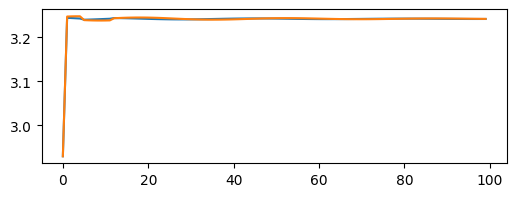

In [465]:
# mixture velocity, inlet and exit
plt.figure(figsize=(6,2))
plt.plot([sol.V_m[0] for sol in sols])
plt.plot([sol.V_m[-1] for sol in sols])

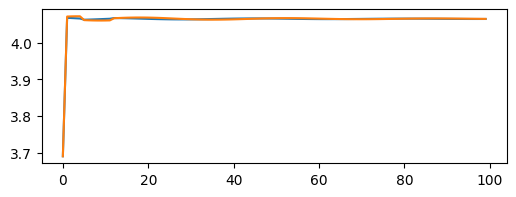

In [466]:
# gas velocity, inlet and exit
plt.figure(figsize=(6,2))
plt.plot([sol.V_g[0] for sol in sols])
plt.plot([sol.V_g[-1] for sol in sols])

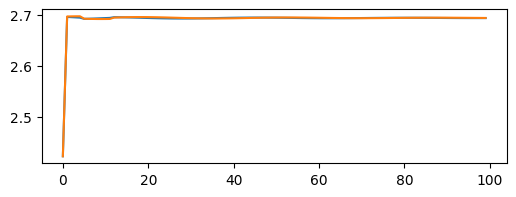

In [467]:
# liquid velocity, inlet and exit
plt.figure(figsize=(6,2))
plt.plot([sol.V_l[0] for sol in sols])
plt.plot([sol.V_l[-1] for sol in sols])

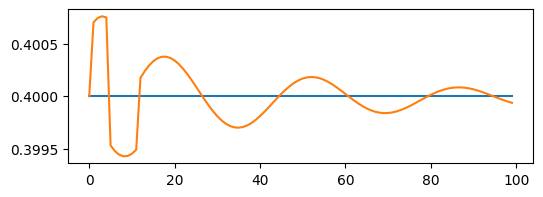

In [468]:
# void fraction, inlet and exit
plt.figure(figsize=(6,2))
plt.plot([sol.alpha_g[0] for sol in sols])
plt.plot([sol.alpha_g[-1] for sol in sols])

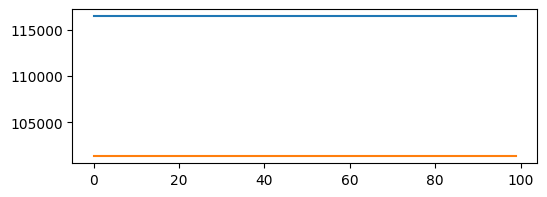

In [469]:
# pressure, inlet and exit
plt.figure(figsize=(6,2))
plt.plot([sol.P[0] for sol in sols])
plt.plot([sol.P[-1] for sol in sols])

np.int64(1)

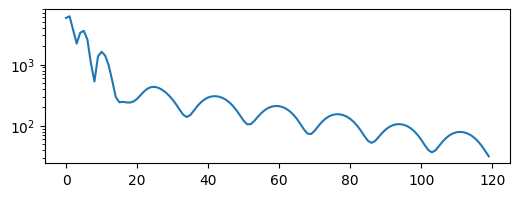

In [470]:
lens = [len(log) for log in logs]
wheremaxlen = np.argmax(lens)

plt.figure(figsize=(6,2))
plt.semilogy(logs[wheremaxlen])
wheremaxlen

In [471]:
for attr in [x for x in dir(sols[-1]) if "__" not in x]:
    print(attr)
    print(getattr(sols[0], attr))
    print(getattr(sols[-1], attr))

P
[116494.         108670.04940986 106222.06354875 103773.83581804
 101325.        ]
[116494.         111089.79780395 108909.14349523 103509.02781568
 101325.        ]
V_g
[3.69069152 3.69065245 3.69069514 3.69073692 3.69069755]
[4.06471242 4.06470441 4.06405415 4.06494681 4.06491443]
V_l
[2.42284549 2.42281734 2.42284953 2.42287832 2.42284989]
[2.6929717  2.69301791 2.69276384 2.69328529 2.6932619 ]
V_m
[2.9299839  2.92995135 2.92998692 2.93002174 2.92998893]
[3.24166798 3.24166131 3.24111943 3.24186332 3.24183633]
alpha_g
[0.4        0.39999997 0.39999932 0.39999998 0.39999998]
[0.4        0.39997726 0.39988293 0.39993688 0.39993688]
rho_g
[1.38438673 1.29140878 1.26231751 1.23322336 1.20412198]
[1.38438673 1.32016449 1.29425012 1.23007644 1.20412198]
